# Kaggle에 있는 braintumor dataset을 기반으로, PSPNet 모델을 이용한 Segmentation 공부 코드 입니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に

        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)
    
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase設定で入力を保存せずに出力を計算し、メモリ削減する

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs
    
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs
    
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )
            
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs
    
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)
    
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)
    
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output
    
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output
    
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [2]:
net = PSPNet(n_classes=2)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Type of device: ", device)

Type of device:  cuda


In [4]:
batch_size = 5
dummy_img = torch.rand(batch_size, 3, 475, 475)

In [5]:
outputs = net(dummy_img)
print(outputs[0].shape)
print(outputs[1].shape)



torch.Size([5, 2, 475, 475])
torch.Size([5, 2, 475, 475])


In [6]:
import random
import math
import time
import pandas as pd
import numpy as np
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms as T

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1232)
np.random.seed(1232)
random.seed(1232)

In [7]:
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

# Setup seeds
torch.manual_seed(1237)
np.random.seed(1237)
random.seed(1237)

import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms as T

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary

In [8]:
ROOT_PATH = "C:/Users/ok/Desktop/archive/lgg-mri-segmentation/kaggle_3m/"

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
print("mask files: ", len(mask_files))

image_files = [file.replace('_mask', '') for file in mask_files]
print("image files: ", len(image_files))

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

mask files:  3929
image files:  3929


In [9]:
files_df

,image_path,mask_path,diagnosis
0,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,0
1,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,1
2,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,1
3,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,1
4,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,1
...,...,...,...
3924,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,0
3925,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,0
3926,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,0
3927,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,C:/Users/ok/Desktop/archive/lgg-mri-segmentati...,0


In [10]:
a = files_df['image_path']

In [11]:
len(a)

3929

In [12]:
a = a.values

In [13]:
a = a.tolist()

In [14]:
print(len(a))
print(a[0])

3929
C:/Users/ok/Desktop/archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif


In [15]:
b = files_df['mask_path']
b = b.values
b = b.tolist()

In [16]:
print(len(b))
print(b[0])

3929
C:/Users/ok/Desktop/archive/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif


In [17]:
class BrainTumorDataset(Dataset):
    
    def __init__(self, df, transformt1=None, transformt2=None):
        self.df = df
        self.transforms = transformt1
        self.transforms_2 = transformt2
    
    def __len__(self):
        return len(self.df['image_path'].values.tolist())
        
    def __getitem__(self, index):
        image_ = self.df['image_path']
        image_ = image_.values
        image_ = image_.tolist()
        image_ = image_[index]
        image_ = Image.open(image_)
        img_arr = np.array(image_)
        
        
        mask_ = self.df['mask_path']
        mask_ = mask_.values
        mask_ = mask_.tolist()
        mask_ = mask_[index]
        mask_ = Image.open(mask_)
        mask_ = np.array(mask_)

        mask_ = mask_ / 255.0
        
        
        
        if self.transforms ==  t1:
            img_ = self.transforms(img_arr)
            
        if self.transforms_2 == t2:
            mask_ = self.transforms_2(mask_)
            mask_ = mask_.squeeze()
            mask_ = mask_.long()
        
        
        return img_, mask_

In [18]:
t1 = tt.Compose([tt.ToTensor(),
                 tt.Resize((475, 475)),
                tt.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
        ])

t2 = tt.Compose([tt.ToTensor(),
                 tt.Resize((475, 475)),
        ])

In [19]:
dataset_ = BrainTumorDataset(files_df,transformt1=t1, transformt2=t2)

In [20]:
print(len(dataset_))

3929


In [21]:
train_loader = DataLoader(dataset_, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset_, batch_size=4, shuffle=True)

In [22]:
q, e = next(iter(train_loader))

In [23]:
print(q.size())
print(e.size())

torch.Size([4, 3, 475, 475])
torch.Size([4, 475, 475])


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Type of device: ", device)

Type of device:  cuda


In [25]:
LEARNING_RATE = 1e-4
num_epochs = 5

In [26]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [27]:
torch.cuda.empty_cache()
train_losses = []
test_losses = []
val_dice = []; val_acc = []
train_dice = []; train_acc = []
lrs = []
min_loss = np.inf
decrease = 1 ; not_improve=0

net = net.to(device)
fit_time = time.time()

print("@@@ Device: ", device, "@@@")


for epoch in range(num_epochs):
    since = time.time()
    running_loss = 0.0
    iou_score = 0
    accuracy = 0.0
    num_correct = 0.0
    num_pixels = 0.0
    dice_score = 0.0
    
    #training loop
    net.train()
    for i, data in enumerate(tqdm(train_loader)):
        
        image_, mask_ = data
        
        if image_.size()[0] == 1:
            continue
            
        image_ = image_.to(device)
        mask_ = mask_.to(device)
        mask_ = mask_.type(torch.long)
        
        # forward
        with torch.cuda.amp.autocast():
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(net(image_)[0]),axis=1)
            num_correct += (preds == mask_).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask_).sum()) / ((preds + mask_).sum() + 1e-8)
            accuracy += num_correct/num_pixels*100
            accuracy = accuracy.item()
            
            predictions = net(image_)
            
            loss = loss_fn(predictions[0], mask_)
            
            
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
    
    else:
        net.eval()
        test_loss = 0.0
        test_accuracy = 0.0
        val_dice_score = 0.0
        val_accuracy = 0.0
        num_correct = 0
        num_pixels = 0
        
        #validation loop
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                #reshape to 9 patches from single image, delete batch size
                image_tiles, mask_tiles = data
                
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)
                
                output = net(image)
                
                #evaluation metrics
                softmax = nn.Softmax(dim=1)
                preds = torch.argmax(softmax(net(image)[0]),axis=1)
                preds = preds.to(device)
                num_correct += (preds == mask).sum()
                num_pixels += torch.numel(preds)
                val_dice_score += (2 * (preds * mask).sum()) / ((preds + mask).sum() + 1e-8)
                val_accuracy += num_correct/num_pixels*100
                val_accuracy = val_accuracy.item()
                
                #loss
                loss = loss_fn(output[0], mask)                                  
                test_loss += loss.item()

        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))

        if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(net, 'PSPNet_NewVersion-{:.3f}.pt'.format(val_dice_score/len(val_loader)))


        if (test_loss/len(val_loader)) > min_loss:
            not_improve += 1
            min_loss = (test_loss/len(val_loader))
            print(f'Loss Not Decrease for {not_improve} time')
            if not_improve == 7:
                print('Loss not decrease for 7 times, Stop Training')
                break

        #iou
        val_dice.append(val_dice_score/len(val_loader))
        train_dice.append(dice_score/len(train_loader))
        train_acc.append(accuracy/len(train_loader))
        val_acc.append(val_accuracy/ len(val_loader))
        print("Epoch:{}/{}..".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
              "Train DICE:{:.3f}..".format(dice_score/len(train_loader)),
              "Val DICE: {:.3f}..".format(val_dice_score/len(val_loader)),
              "Train Pixel Acc:{:.3f}..".format(accuracy/len(train_loader)),
              "Val Pixel Acc:{:.3f}..".format(val_accuracy/len(val_loader)),
              "Time: {:.2f}m".format((time.time()-since)/60))

@@@ Device:  cuda @@@


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.019 
Epoch:1/5.. Train Loss: 0.041.. Val Loss: 0.019.. Train DICE:0.365.. Val DICE: 0.434.. Train Pixel Acc:97.941.. Val Pixel Acc:99.403.. Time: 7.15m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.019 >> 0.013 
Epoch:2/5.. Train Loss: 0.017.. Val Loss: 0.013.. Train DICE:0.485.. Val DICE: 0.494.. Train Pixel Acc:99.338.. Val Pixel Acc:99.545.. Time: 7.05m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/5.. Train Loss: 0.013.. Val Loss: 0.013.. Train DICE:0.535.. Val DICE: 0.535.. Train Pixel Acc:99.448.. Val Pixel Acc:99.579.. Time: 7.18m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.013 >> 0.010 
Epoch:4/5.. Train Loss: 0.012.. Val Loss: 0.010.. Train DICE:0.564.. Val DICE: 0.552.. Train Pixel Acc:99.486.. Val Pixel Acc:99.647.. Time: 7.16m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.010 >> 0.008 
saving model...
Epoch:5/5.. Train Loss: 0.009.. Val Loss: 0.008.. Train DICE:0.606.. Val DICE: 0.609.. Train Pixel Acc:99.561.. Val Pixel Acc:99.679.. Time: 7.17m


In [39]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_DICE' :train_dice, 'val_DICE':val_dice,
           'train_acc' :train_acc, 'val_acc':val_acc,
           'lrs': lrs}

print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))

Total time: 42.68 m


In [40]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    x_cpu = list(t.cpu() for t in history['train_DICE'])
    x_cpu_val = list(w.cpu() for w in history['val_DICE'])
    #print(x_cpu)
    #print(x_cpu_val)
    plt.plot(x_cpu, label='train_DICE', marker='*')
    plt.plot(x_cpu_val, label='val_DICE',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    

def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, float): return np.array(v) # <-- Added this line
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if torch.cuda.is_available() and is_half_tensor(v): v=v.float()
    if isinstance(v, torch.FloatTensor): v=v.float()
    return v.cpu().numpy()


In [41]:
def plot_acc(history):
    x_cpu_acc = list(to_np(t) for t in history['train_acc'])
    x_cpu_val_acc = list(to_np(w) for w in history['val_acc'])
    #print(x_cpu_acc)
    #print(x_cpu_val_acc)
    plt.plot(x_cpu_acc, label='train_accuracy', marker='*')
    plt.plot(x_cpu_val_acc, label='val_accuracy',  marker='*')
    #plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    #plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

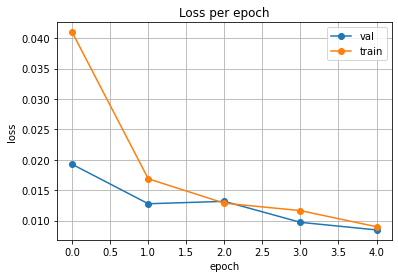

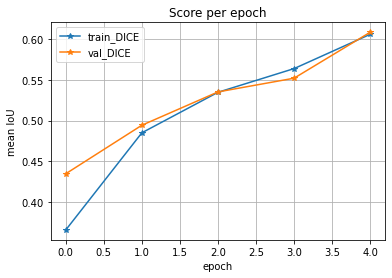

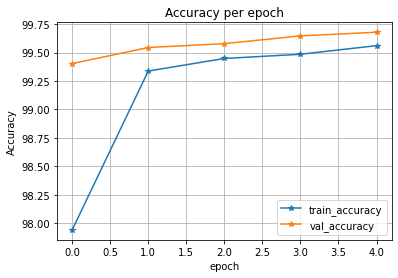

In [42]:
plot_loss(history)
plot_score(history)
plot_acc(history)